In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from google.cloud import storage
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Function to get data

def get_stock_data_from_gcp(nrows=10000, local=False, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/amazon_stock_price.csv"
    df = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    return df

In [3]:
df = get_stock_data_from_gcp()

In [4]:
df = df.sort_values('date', ascending=True).reset_index(drop=True)

In [5]:
df

,date,AMZN
0,1999-11-01,69.13
1,1999-11-02,66.44
2,1999-11-03,65.81
3,1999-11-04,63.06
4,1999-11-05,64.94
...,...,...
5547,2021-11-16,3540.70
5548,2021-11-17,3549.00
5549,2021-11-18,3696.06
5550,2021-11-19,3676.57


In [6]:
X = df[['AMZN']]

In [7]:
X

,AMZN
0,69.13
1,66.44
2,65.81
3,63.06
4,64.94
...,...
5547,3540.70
5548,3549.00
5549,3696.06
5550,3676.57


In [8]:
# Function to scale data

def scale_stock_data(df, ticker):
    X = df[[ticker]]
    sc = MinMaxScaler().fit(X)
    X_sc = sc.fit_transform(X)
    return sc, X_sc

In [9]:
# Function to split scaled data

def split_stock_data(X_sc, train_size):
    index = round(train_size*X_sc.shape[0])
    X_sc_train = X_sc[:index]
    X_sc_test = X_sc[index:]
    return X_sc_train, X_sc_test

In [10]:
# Function to reshape scaled train data

def reshape_train_data(X_sc_train, obs):
    X_train = []
    y_train = []
    for i in range(obs, X_sc_train.shape[0]):
        X_train.append(X_sc_train[i-obs:i, 0])
        y_train.append(X_sc_train[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train

In [11]:
# Function to reshape scaled test data

def reshape_test_data(X_sc_test, obs):
    X_test = []
    y_test = []
    for i in range(obs, X_sc_test.shape[0]):
        X_test.append(X_sc_test[i-obs:i, 0])
        y_test.append(X_sc_test[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test, y_test

In [12]:
# Function to inverse transform

def inverse_transformer(y):
    y = np.c_[y, np.ones(len(y))]
    y = scaler.inverse_transform(y)
    y = y[:,0]
    return y

In [13]:
# Function to build the lstm model

def lstm_model():
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [14]:
# Function to train the model

def train_model(X_train, y_train):   
    model = lstm_model()
    es = EarlyStopping(patience=30, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[es], verbose=1)
    return model

In [15]:
# Function to predict results

def predict_model(ticker):
    sc, X_sc = scale_stock_data(df, ticker) 
    X_sc_train, X_sc_test = split_stock_data(X_sc, 0.8)
    X_train, y_train = reshape_train_data(X_sc_train, 30)
    X_test, y_test = reshape_test_data(X_sc_test, 30)
    #sc = MinMaxScaler().fit(X)
    model = train_model(X_train, y_train)
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    return predicted_stock_price

In [16]:
#prediction = predict_model('AMZN')

In [17]:
#prediction

In [18]:
#plt.plot(prediction);

In [19]:
def model_training(ticker):
    sc, X_sc = scale_stock_data(df, ticker) 
    X_sc_train, X_sc_test = split_stock_data(X_sc, 0.8)
    X_train, y_train = reshape_train_data(X_sc_train, 30)
    X_test, y_test = reshape_test_data(X_sc_test, 30)
    model = train_model(X_train, y_train)
    return model

In [20]:
model = model_training('AMZN')

2021-12-01 17:38:39.102287: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-01 17:38:39.201203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
111/111 [==============================] - 11s 47ms/step - loss: 8.0711e-05 - val_loss: 7.5661e-05
Epoch 2/100
111/111 [==============================] - 4s 37ms/step - loss: 1.6883e-05 - val_loss: 9.8303e-05
Epoch 3/100
111/111 [==============================] - 4s 37ms/step - loss: 1.7229e-05 - val_loss: 6.3244e-05
Epoch 4/100
111/111 [==============================] - 4s 37ms/step - loss: 1.5039e-05 - val_loss: 8.2115e-05
Epoch 5/100
111/111 [==============================] - 4s 38ms/step - loss: 1.6085e-05 - val_loss: 6.0535e-05
Epoch 6/100
111/111 [==============================] - 4s 37ms/step - loss: 1.3786e-05 - val_loss: 1.9408e-04
Epoch 7/100
111/111 [==============================] - 7s 60ms/step - loss: 1.3474e-05 - val_loss: 7.5039e-05
Epoch 8/100
111/111 [==============================] - 5s 42ms/step - loss: 1.2949e-05 - val_loss: 6.5985e-05
Epoch 9/100
111/111 [==============================] - 4s 37ms/step - loss: 1.2141e-05 - val_loss: 1.1881e-04
Epoch 10/

Epoch 75/100
111/111 [==============================] - 4s 38ms/step - loss: 8.0530e-06 - val_loss: 8.2345e-05
Epoch 76/100
111/111 [==============================] - 4s 37ms/step - loss: 6.9353e-06 - val_loss: 2.7942e-05
Epoch 77/100
111/111 [==============================] - 4s 38ms/step - loss: 7.2023e-06 - val_loss: 2.9665e-05
Epoch 78/100
111/111 [==============================] - 4s 38ms/step - loss: 7.8337e-06 - val_loss: 4.2591e-05
Epoch 79/100
111/111 [==============================] - 4s 38ms/step - loss: 6.9697e-06 - val_loss: 3.5883e-05
Epoch 80/100
111/111 [==============================] - 4s 38ms/step - loss: 6.8222e-06 - val_loss: 5.6885e-05
Epoch 81/100
111/111 [==============================] - 4s 38ms/step - loss: 6.8373e-06 - val_loss: 2.3513e-05
Epoch 82/100
111/111 [==============================] - 4s 38ms/step - loss: 8.1237e-06 - val_loss: 3.7227e-05
Epoch 83/100
111/111 [==============================] - 4s 38ms/step - loss: 6.8067e-06 - val_loss: 2.3731e-05
E

In [21]:
def reshape_data(X_sc, obs):
    X_final = []
    for i in range(obs, X_sc.shape[0]):
        X_final.append(X_sc[i-obs:i, 0])
    X_final = np.array(X_final)
    X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))
    return X_final

In [22]:
sc, X_sc = scale_stock_data(df, 'AMZN')

In [23]:
X_sc.shape

(5552, 1)

In [24]:
X_final = reshape_data(X_sc, 30)

In [25]:
X_final.shape

(5522, 30, 1)

In [26]:
final_predictions = model.predict(X_final)

In [27]:
final_predictions

array([[0.02224883],
       [0.02297795],
       [0.02343489],
       ...,
       [0.682509  ],
       [0.68353224],
       [0.6850415 ]], dtype=float32)

In [28]:
final_predictions = sc.inverse_transform(final_predictions)
final_predictions

array([[  88.85669],
       [  91.57298],
       [  93.27529],
       ...,
       [2548.6162 ],
       [2552.4282 ],
       [2558.0508 ]], dtype=float32)

In [29]:
final_predictions.shape

(5522, 1)

In [30]:
df = df.drop(df.head(30).index)

In [31]:
df['predictions'] = final_predictions

In [32]:
df

,date,AMZN,predictions
30,1999-12-14,95.63,88.856689
31,1999-12-15,96.50,91.572983
32,1999-12-16,94.88,93.275291
33,1999-12-17,94.06,93.864502
34,1999-12-20,97.00,93.531158
...,...,...,...
5547,2021-11-16,3540.70,2543.414551
5548,2021-11-17,3549.00,2546.236328
5549,2021-11-18,3696.06,2548.616211
5550,2021-11-19,3676.57,2552.428223


In [33]:
#df.to_csv('model1_predictions.csv', index=False)

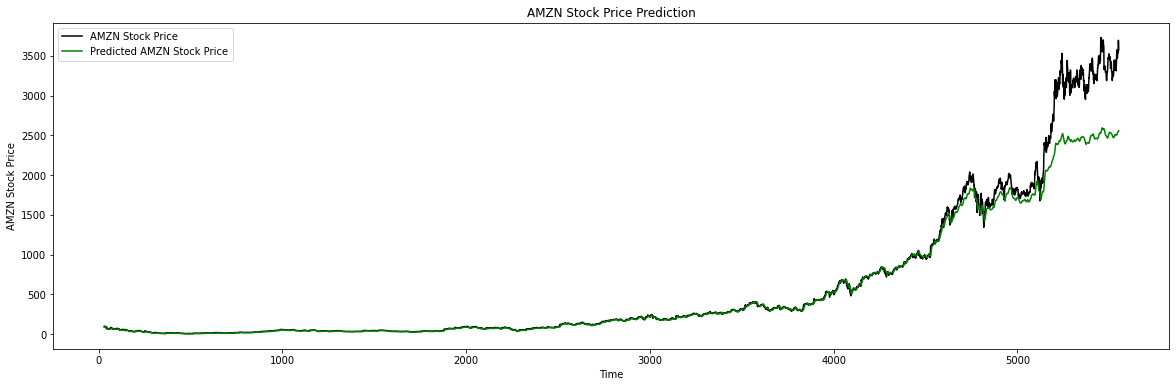

In [34]:
plt.figure(figsize=(20, 6))
plt.plot(df['AMZN'], color = 'black', label = 'AMZN Stock Price')
plt.plot(df['predictions'], color = 'green', label = 'Predicted AMZN Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.show()

In [35]:
#from keras.models import load_model

#model.save('stock_price.h5')

In [36]:
#model_test = load_model('lstm_model_stock_price.h5')

In [37]:
#sc, X_sc = scale_stock_data(df, 'AMZN')

In [38]:
#X_sc_train, X_sc_test = split_stock_data(X_sc, 0.8)

In [39]:
#X_train, y_train = reshape_train_data(X_sc_train, 30)

In [40]:
#X_test, y_test = reshape_test_data(X_sc_test, 30)

In [41]:
#y_pred = model_test.predict(X_test)

In [42]:
#y_pred